In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.miscmodels.ordinal_model import OrderedModel

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv('source/FReDA2.csv')

In [3]:
def val_to_category(val):
    if val < 0.5:
        return 0
    elif val < 2:
        return 1
    elif val < 3:
        return 2
    elif val < 4:
        return 3
    elif val < 5:
        return 4
    else:
        return 5


df['Anchor FreqCat'] = df['Anchor Frequency of Touch'].apply(val_to_category)
df['Anchor WishCat'] = df['Anchor Wish for Touch'].apply(val_to_category)
df['Partner FreqCat'] = df['Partner Frequency of Touch'].apply(val_to_category)
df['Partner WishCat'] = df['Partner Wish for Touch'].apply(val_to_category)
df['Couple FreqCat'] = df['Couple Frequency of Touch'].apply(val_to_category)
df['Couple WishCat'] = df['Couple Wish for Touch'].apply(val_to_category)

In [26]:
predictors = [
    'Anchor Difference of Touch',
    'Anchor Age',
    'Anchor Work Status',
    'Anchor East',
    'Anchor Urbanization',
    'Anchor Extraversion',
    'Anchor Agreeableness',
    'Anchor Conscientiousness',
    'Anchor Openness',
    'Anchor Neuroticism',
    'Anchor Conservatism',
    'Anchor Religiosity',
    'Anchor Depressiveness',
    'Anchor Loneliness',
    'Anchor Self-esteem',
    'Anchor Life Satisfaction',
    'Anchor Health',
    'Anchor Communication Quality',
    'Anchor Relationship Satisfaction',
    'Anchor Conflict Management',

    'Partner Difference of Touch',
    'Partner Age',
    'Partner Work Status',
    'Partner East',
    'Partner Urbanization',
    'Partner Extraversion',
    'Partner Agreeableness',
    'Partner Conscientiousness',
    'Partner Openness',
    'Partner Neuroticism',
    'Partner Conservatism',
    'Partner Religiosity',
    'Partner Depressiveness',
    'Partner Loneliness',
    'Partner Self-esteem',
    'Partner Life Satisfaction',
    'Partner Health',
    'Partner Communication Quality',
    'Partner Relationship Satisfaction',
    'Partner Conflict Management',

    'Relationship Sex',
    'Relationship Length',
    'Age difference',
    'Married',
    'Cohabitation',
    'Kids',
]

anchor_predictors = [
    'Anchor Difference of Touch',

    'Anchor Age',
    'Anchor Work Status',
    'Anchor East',
    'Anchor Urbanization',

    'Anchor Extraversion',
    'Anchor Agreeableness',
    'Anchor Conscientiousness',
    'Anchor Openness',
    'Anchor Neuroticism',
    'Anchor Conservatism',
    'Anchor Religiosity',

    'Anchor Depressiveness',
    'Anchor Loneliness',
    'Anchor Self-esteem',
    'Anchor Life Satisfaction',
    'Anchor Health',

    'Anchor Communication Quality',
    'Anchor Relationship Satisfaction',
    'Anchor Conflict Management',

    'Relationship Sex',
    'Relationship Length',
    'Age difference',
    'Married',
    'Cohabitation',
    'Kids',
]

partner_predictors = [
    'Partner Difference of Touch',

    'Partner Age',
    'Partner Work Status',
    'Partner East',
    'Partner Urbanization',

    'Partner Extraversion',
    'Partner Agreeableness',
    'Partner Conscientiousness',
    'Partner Openness',
    'Partner Neuroticism',
    'Partner Conservatism',
    'Partner Religiosity',

    'Partner Depressiveness',
    'Partner Loneliness',
    'Partner Self-esteem',
    'Partner Life Satisfaction',
    'Partner Health',
    'Partner Communication Quality',
    'Partner Relationship Satisfaction',
    'Partner Conflict Management',

    'Relationship Sex',
    'Relationship Length',
    'Age difference',
    'Married',
    'Cohabitation',
    'Kids',
]

In [5]:
anchor_dependent = [
    'Anchor FreqCat',
    'Anchor WishCat',
    # 'Anchor Frequency of Touch',
    # 'Anchor Wish for Touch'
]
partner_dependent = [
    'Partner FreqCat',
    'Partner WishCat',
]
couple_dependent = [
    'Couple FreqCat',
    'Couple WishCat',
]

In [6]:
df['Group'].value_counts()

Group
Disagreement    3131
Agreement       1922
Concession      1746
Name: count, dtype: int64

In [7]:
df['SubGroup'].value_counts()

SubGroup
Disagreement                3131
Deprived Agreement          1701
High Frequency Agreement    1509
Low Frequency Agreement      405
Saturated Agreement           45
Non-Touch Agreement            8
Name: count, dtype: int64

In [8]:
df = df.dropna().reset_index(drop=True)

In [9]:
group_agreement = df[df['Group'] == 'Agreement'].dropna().reset_index(drop=True)
group_disagreement = df[df['Group'] == 'Disagreement'].dropna().reset_index(drop=True)
group_concession = df[df['Group'] == 'Concession'].dropna().reset_index(drop=True)

In [10]:
x = df[predictors]
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif["Variable"] = x.columns

# https://support.minitab.com/en-us/minitab/help-and-how-to/statistical-modeling/regression/how-to/fit-binary-logistic-model/interpret-the-results/all-statistics-and-graphs/coefficients-and-regression-equation/
# VIF 	Multicollinearity
# VIF = 1 	None
# 1 < VIF < 5 	Moderate
# VIF > 5 	High

print(vif.sort_values(by="VIF", ascending=False))

           VIF                           Variable
1   179.332458                         Anchor Age
21  158.943769                        Partner Age
19  100.795791         Anchor Conflict Management
37   98.779078      Partner Communication Quality
39   98.372043        Partner Conflict Management
17   93.230250       Anchor Communication Quality
18   58.457083   Anchor Relationship Satisfaction
38   57.385490  Partner Relationship Satisfaction
35   48.126330          Partner Life Satisfaction
14   45.901892                 Anchor Self-esteem
34   44.788796                Partner Self-esteem
15   44.114796           Anchor Life Satisfaction
6    37.275920               Anchor Agreeableness
26   36.435946              Partner Agreeableness
16   34.980469                      Anchor Health
7    32.560046           Anchor Conscientiousness
36   32.108317                     Partner Health
3    32.015978                        Anchor East
27   30.982468          Partner Conscientiousness


In [11]:

from sklearn.linear_model import LinearRegression
from sklearn.inspection import permutation_importance

X = df[predictors]
y = df["Couple FreqCat"]

model = LinearRegression()
model.fit(X, y)  # X: your predictors, y: dependent variable

result = permutation_importance(model, X, y, n_repeats=30, random_state=42)
importances = result.importances_mean

feature_names = X.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df['Cumulative'] = importance_df['Importance'].cumsum()
importance_df['Cumulative %'] = importance_df['Cumulative'] / importance_df['Importance'].sum()

top_predictors = importance_df[importance_df['Cumulative %'] <= 0.95]
print(top_predictors)

                              Feature  Importance  Cumulative  Cumulative %
20        Partner Difference of Touch    0.087802    0.087802      0.226388
0          Anchor Difference of Touch    0.073676    0.161478      0.416354
17       Anchor Communication Quality    0.050025    0.211503      0.545339
37      Partner Communication Quality    0.042901    0.254404      0.655955
38  Partner Relationship Satisfaction    0.025369    0.279772      0.721366
18   Anchor Relationship Satisfaction    0.023811    0.303583      0.782760
41                Relationship Length    0.022739    0.326322      0.841390
44                       Cohabitation    0.005633    0.331955      0.855913
12              Anchor Depressiveness    0.004677    0.336632      0.867972
5                 Anchor Extraversion    0.004564    0.341195      0.879740
43                            Married    0.004120    0.345315      0.890363
25               Partner Extraversion    0.003713    0.349028      0.899936
45          

In [12]:
X = df[predictors]
y = df["Couple WishCat"]

model = LinearRegression()
model.fit(X, y)  # X: your predictors, y: dependent variable

result = permutation_importance(model, X, y, n_repeats=30, random_state=42)
importances = result.importances_mean

feature_names = X.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df['Cumulative'] = importance_df['Importance'].cumsum()
importance_df['Cumulative %'] = importance_df['Cumulative'] / importance_df['Importance'].sum()

top_predictors = importance_df[importance_df['Cumulative %'] <= 0.95]
print(top_predictors)

                              Feature  Importance  Cumulative  Cumulative %
37      Partner Communication Quality    0.067917    0.067917      0.146880
17       Anchor Communication Quality    0.066824    0.134741      0.291395
20        Partner Difference of Touch    0.065258    0.200000      0.432524
0          Anchor Difference of Touch    0.060443    0.260443      0.563240
18   Anchor Relationship Satisfaction    0.038328    0.298770      0.646129
41                Relationship Length    0.036479    0.335249      0.725019
38  Partner Relationship Satisfaction    0.035725    0.370975      0.802280
21                        Partner Age    0.011277    0.382251      0.826667
12              Anchor Depressiveness    0.009470    0.391721      0.847147
44                       Cohabitation    0.006850    0.398572      0.861961
26              Partner Agreeableness    0.006450    0.405021      0.875910
25               Partner Extraversion    0.005597    0.410618      0.888014
22          

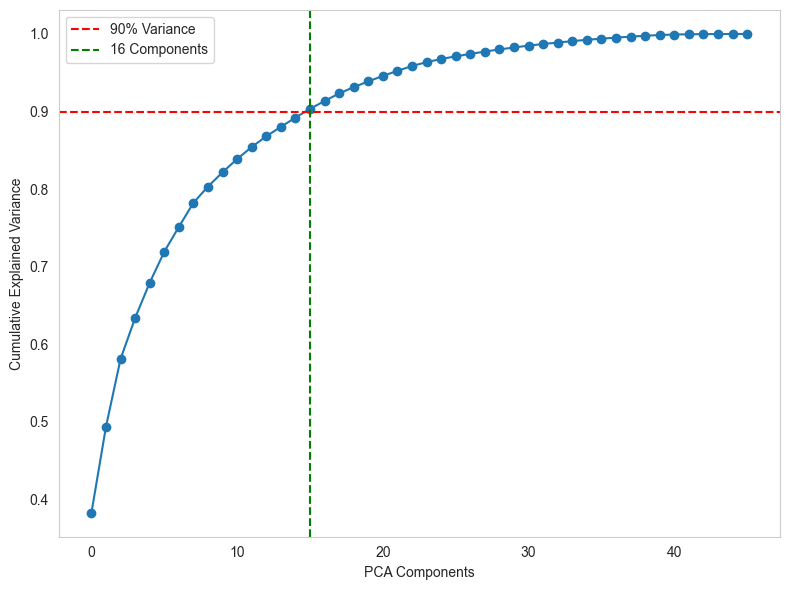

In [13]:
target_predictors = predictors
target_variance = 0.9

x = df[target_predictors]
# X_scaled = StandardScaler().fit_transform(X)
# Specific statistical transformation involving subtraction of the average and subsequent division by
# the standard deviation.

pca = PCA()
x_pca = pca.fit_transform(x)

# Cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find number of components to reach target % variance
n_components_90 = np.argmax(cumulative_variance >= target_variance) + 1  # +1 because index starts at 0

# Plot
plt.figure(figsize=(8, 6))
plt.plot(cumulative_variance, marker='o')
plt.axhline(y=target_variance, color='r', linestyle='--', label=f'{int(target_variance * 100)}% Variance')
plt.axvline(x=n_components_90 - 1, color='g', linestyle='--',
            label=f'{n_components_90} Components')  # subtract 1 for correct index on plot
plt.xlabel('PCA Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(False)
plt.legend()
plt.tight_layout()
plt.show()

In [14]:
# Keep only the first `n_components_90` components
x_pca_90 = x_pca[:, :n_components_90]
pca_df = pd.DataFrame(x_pca_90, columns=[f'PC{i + 1}' for i in range(n_components_90)])

# Slice the loadings too
loadings = pd.DataFrame(pca.components_.T[:, :n_components_90],
                        columns=[f'PC{i + 1}' for i in range(n_components_90)],
                        index=target_predictors)

In [15]:
print(x.columns)

Index(['Anchor Difference of Touch', 'Anchor Age', 'Anchor Work Status',
       'Anchor East', 'Anchor Urbanization', 'Anchor Extraversion',
       'Anchor Agreeableness', 'Anchor Conscientiousness', 'Anchor Openness',
       'Anchor Neuroticism', 'Anchor Conservatism', 'Anchor Religiosity',
       'Anchor Depressiveness', 'Anchor Loneliness', 'Anchor Self-esteem',
       'Anchor Life Satisfaction', 'Anchor Health',
       'Anchor Communication Quality', 'Anchor Relationship Satisfaction',
       'Anchor Conflict Management', 'Partner Difference of Touch',
       'Partner Age', 'Partner Work Status', 'Partner East',
       'Partner Urbanization', 'Partner Extraversion', 'Partner Agreeableness',
       'Partner Conscientiousness', 'Partner Openness', 'Partner Neuroticism',
       'Partner Conservatism', 'Partner Religiosity', 'Partner Depressiveness',
       'Partner Loneliness', 'Partner Self-esteem',
       'Partner Life Satisfaction', 'Partner Health',
       'Partner Communication Q

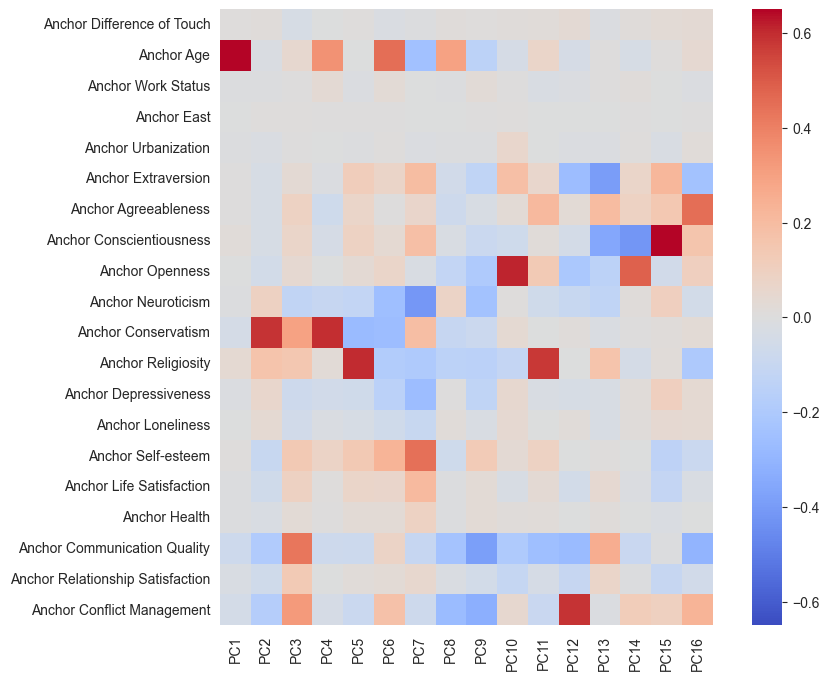

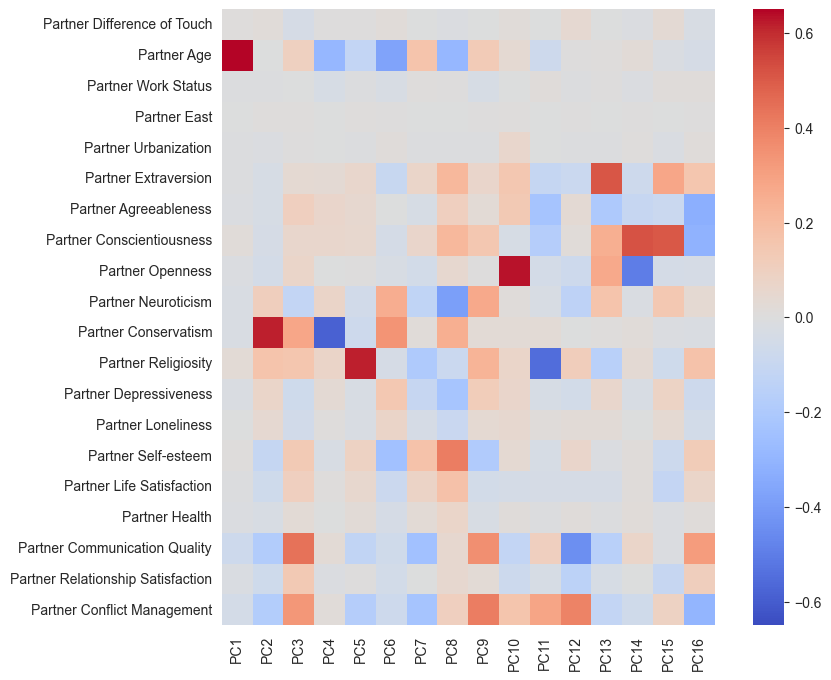

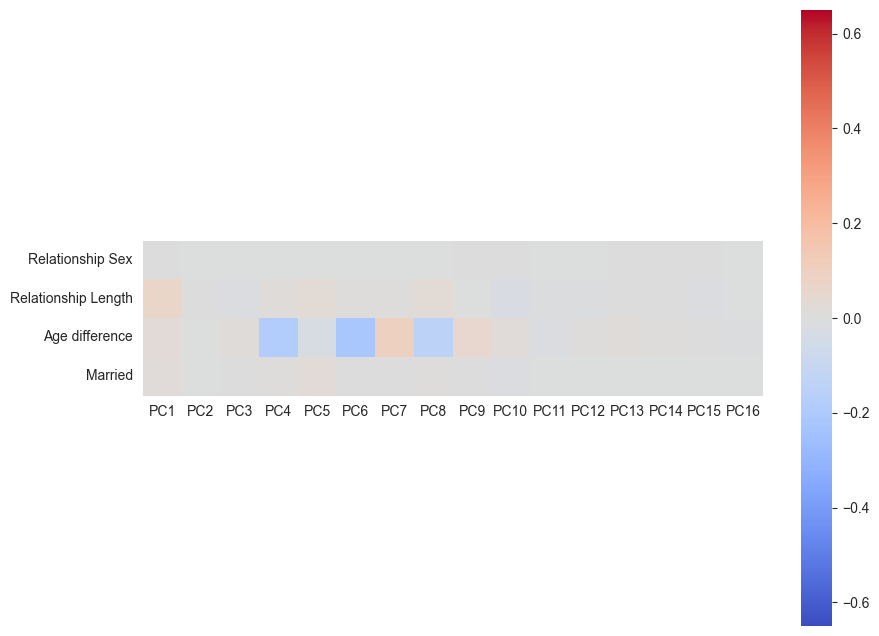

In [16]:
# loadings_df = pd.DataFrame(pca.components_.T, index=x.columns, columns=[f'PC{i + 1}' for i in range(pca.n_components_)])
plt.figure(figsize=(10, 8))
sns.heatmap(loadings.iloc[0:20, :16],
            cmap="coolwarm",
            center=0,
            vmax=0.65,
            vmin=-0.65,
            square=True,
            )
plt.savefig('output/img_bg/loadings1.png', dpi=350, transparent=False, bbox_inches='tight')
# plt.title("PCA Loadings")
plt.show()
plt.figure(figsize=(10, 8))
sns.heatmap(loadings.iloc[20:40, :16],
            cmap="coolwarm",
            center=0,
            vmax=0.65,
            vmin=-0.65,
            square=True,
            )
plt.savefig('output/img_bg/loadings2.png', dpi=350, transparent=False, bbox_inches='tight')
# plt.title("PCA Loadings")
plt.show()
plt.figure(figsize=(10, 8))
sns.heatmap(loadings.iloc[40:44, :16],
            cmap="coolwarm",
            center=0,
            vmax=0.65,
            vmin=-0.65,
            square=True,
            )
plt.savefig('output/img_bg/loadings3.png', dpi=350, transparent=False, bbox_inches='tight')
# plt.title("PCA Loadings")
plt.show()

In [17]:
# loadings['PC16'].sort_values(key=abs, ascending=False).head(10)

Optimization terminated successfully.
         Current function value: 1.244797
         Iterations: 28
         Function evaluations: 33
         Gradient evaluations: 33


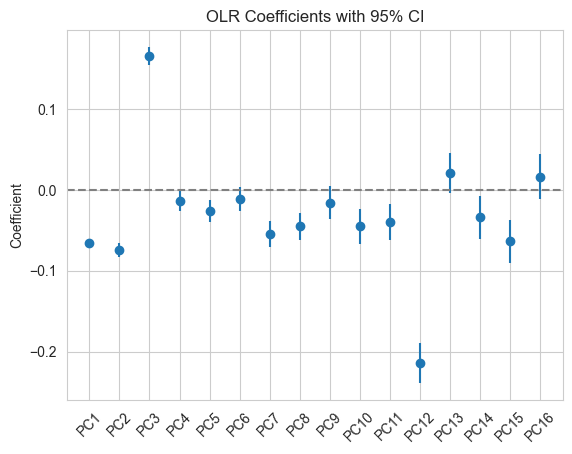

                             OrderedModel Results                             
Dep. Variable:         Couple FreqCat   Log-Likelihood:                -5938.9
Model:                   OrderedModel   AIC:                         1.192e+04
Method:            Maximum Likelihood   BIC:                         1.206e+04
Date:                Wed, 03 Sep 2025                                         
Time:                        14:55:28                                         
No. Observations:                4771                                         
Df Residuals:                    4750                                         
Df Model:                          16                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
PC1           -0.0657      0.003    -25.700      0.000      -0.071      -0.061
PC2           -0.0742      0.005    -16.203      0.0

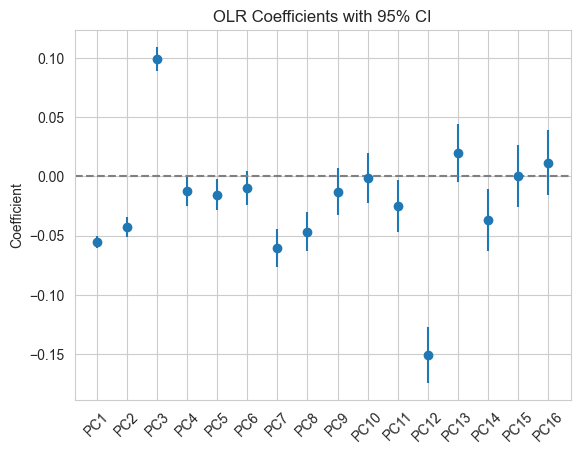

                             OrderedModel Results                             
Dep. Variable:         Couple WishCat   Log-Likelihood:                -6086.8
Model:                   OrderedModel   AIC:                         1.222e+04
Method:            Maximum Likelihood   BIC:                         1.235e+04
Date:                Wed, 03 Sep 2025                                         
Time:                        14:55:31                                         
No. Observations:                4771                                         
Df Residuals:                    4750                                         
Df Model:                          16                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
PC1           -0.0554      0.002    -22.272      0.000      -0.060      -0.050
PC2           -0.0427      0.004     -9.619      0.0

In [35]:
x = pca_df

for d in couple_dependent:
    y = df[d]
    mod = OrderedModel(y, x, distr='logit')
    res = mod.fit(method='bfgs')

    coefs = res.params
    coefs = coefs.iloc[:16]
    conf = res.conf_int()
    conf = conf.iloc[:16, :]
    plt.errorbar(coefs.index, coefs.values,
                 yerr=[coefs.values - conf[0], conf[1] - coefs.values],
                 fmt='o')
    plt.axhline(0, color='grey', linestyle='--')
    plt.xticks(rotation=45)
    plt.ylabel('Coefficient')
    plt.title('OLR Coefficients with 95% CI')
    plt.show()
    print(res.summary())

# x = df[anchor_predictors]
#
# y = df["Couple FreqCat"]
# mod = OrderedModel(y, x, distr='logit')
# res = mod.fit(method='bfgs')
# print(res.summary())



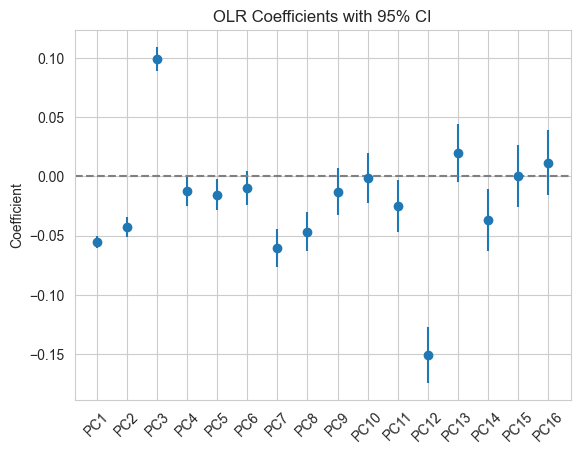

In [34]:
coefs = res.params
coefs = coefs.iloc[:16]
conf = res.conf_int()
conf = conf.iloc[:16, :]
plt.errorbar(coefs.index, coefs.values,
             yerr=[coefs.values - conf[0], conf[1] - coefs.values],
             fmt='o')
plt.axhline(0, color='grey', linestyle='--')
plt.xticks(rotation=45)
plt.ylabel('Coefficient')
plt.title('OLR Coefficients with 95% CI')
plt.show()

In [19]:
# Check for robutness, p values are similar although coeff may vary
# x = pca_df
# x = sm.add_constant(x)
#
# test = [
#     'Couple Frequency of Touch',
#     'Couple Wish for Touch',
# ]
#
# for d in test:
#     y = df[d]
#     model_freq = sm.OLS(y, x, missing='drop').fit()
#     print(model_freq.summary())

In [20]:
# test_group = df[df['SubGroup'] == 'High Frequency Agreement']
# test_group = df[df['SubGroup'] == 'Low Frequency Agreement']
# test_group = df[df['Group'] == 'Concession']
# test_group = df[df['Group'] == 'Agreement']
# test_group = df[df['Group'] == 'Disagreement']

# print(test_group['Id'].size)

In [ ]:
all_radar = merged.groupby(['Segment', 'Gender', 'Type'])['Marked']
estimates = all_radar.mean().reset_index()
estimates = estimates.rename(columns={'Marked': 'Mean_Marked'})

for i, t in enumerate(genders):
    pivot_df = estimates[estimates['Gender'] == t].pivot(
        index='Type',
        columns='Segment',
        values='Mean_Marked'
    )
    categories = list(pivot_df.columns)
    N = len(categories)

    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

    for idx, row in pivot_df.iterrows():
        values = row.tolist()
        values += values[:1]
        if idx == "Other":
            ax.plot(angles, values, label=idx, color=colors[0])
            ax.fill(angles, values, alpha=0.1, color=colors[0])
        elif idx == "Self":
            ax.plot(angles, values, label=idx, color=colors[1])
            ax.fill(angles, values, alpha=0.1, color=colors[1])

    ticks = [0.25, 0.50, 0.75, 1]
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    ax.set_yticks(ticks)
    ax.set_title(f'Body Odor Ratings ({t})')
    ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
    plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
    # plt.savefig('output/radar-' + t + '.png', dpi=350, bbox_inches='tight')
    plt.show()